In [ ]:
!pip install tensorflow --quiet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


ImportError: cannot import name 'train_test_split' from 'sklearn.preprocessing' (/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/__init__.py)

In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/dataset/synthetic_fatigue_data_adaptive.csv")
print(df.shape)
df.head()

(1048575, 15)


cycle  mean_amplitude          load  median_strain  pzt_amplitude_std  \
0      0     1586.786000  0.000000e+00       0.002300         235.715700   
1      1     1817.957900  5.000000e-01       0.002300         432.599550   
2      2     1701.650839  3.759799e-01       0.002906         460.203918   
3      3     1436.578100 -4.160000e-17       0.003731         408.923400   
4      4     1187.801163 -3.192490e-01       0.004453         353.963329   

   pzt_energy_mean  pzt_rms_mean  strain_mean_of_means  strain_std_of_means  \
0      396967580.0    439.628020              0.001982             0.001511   
1      589382850.0    516.628970              0.001982             0.001511   
2      520264726.4    480.389778              0.002395             0.001607   
3      337786850.0    395.538020              0.002956             0.001738   
4      165055721.5    315.759162              0.003448             0.001851   

      rho_micro   D_macro    rho_smooth  D_smooth     RUL coupon_id  
0  0.000000e+00  1.000000  0.000000e+00  1.000000  300000    L3_S13  
1  2.860000e-17  1.000000  6.470000e-18  1.000000  299999    L3_S13  
2  3.979975e-02  0.837691  2.269945e-02  0.907472  299998    L3_S13  
3  9.466171e-02  0.616466  5.409241e-02  0.780838  299997    L3_S13  
4  1.440743e-01  0.422002  8.256350e-02  0.668519  299996    L3_S13

In [4]:
df_L1 = df[df['coupon_id'].str.startswith('L1')].copy()
df_L1 = df_L1.sort_values('cycle').reset_index(drop=True)
print("Shape:", df_L1.shape)

Shape: (391572, 15)


In [5]:
features = [
    'strain_std_of_means',
    'pzt_amplitude_std',
    'mean_amplitude',
    'strain_mean_of_means',
    'pzt_energy_mean',
    'rho_smooth',
    'D_smooth',
    'D_macro',
    'load'
]
target = 'RUL'

In [11]:
# normalize RUL between 0 and 1
df_L1['RUL_norm'] = df_L1['RUL'] / df_L1['RUL'].max()
target = 'RUL_norm'

In [12]:
import numpy as np

def make_sliding_windows(df, features, target, window=50):
    X, y = [], []
    vals = df[features].values
    y_vals = df[target].values
    for i in range(window, len(df)):
        X.append(vals[i-window:i])
        y.append(y_vals[i])
    return np.array(X), np.array(y)

window_size = 50
X, y = make_sliding_windows(df_L1, features, target, window_size)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (391522, 50, 9) y shape: (391522,)


In [13]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, len(features))
X_test_2d  = X_test.reshape(-1, len(features))

scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape)

In [15]:
n_timesteps = X_train_scaled.shape[1]   # 50
n_features  = X_train_scaled.shape[2]   # 9

model = keras.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0533 - val_loss: 1.0731
Epoch 2/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0356 - val_loss: 0.9277
Epoch 3/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0343 - val_loss: 0.7673
Epoch 4/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0334 - val_loss: 0.3326
Epoch 5/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0328 - val_loss: 0.0754
Epoch 6/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0320 - val_loss: 0.1372
Epoch 7/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0317 - val_loss: 0.0669
Epoch 8/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0314 - val_loss: 0.0772
Epoch 9/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0310 - val_loss: 0.0342
Epoch 10/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0308 - val_loss: 0.0368
Epoch 11/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0305 - val_loss: 0.0435
Epoch 12/50
3916/39

In [17]:
y_pred_norm = model.predict(X_test_scaled).flatten()

# convert back to original RUL scale
rul_max = df_L1['RUL'].max()
y_pred = y_pred_norm * rul_max
y_true = y_test * rul_max

2448/2448 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


RMSE: 175911.31, MAE: 162493.19, R²: -59.561


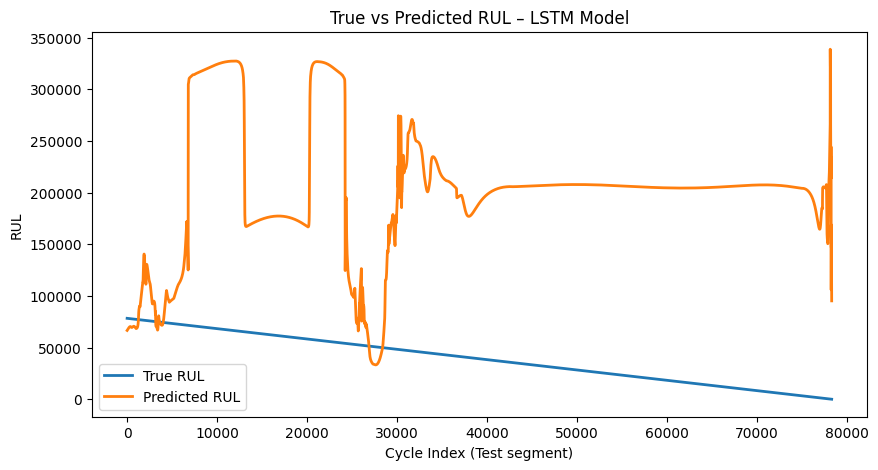

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Evaluate ===
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# === Plot ===
plt.figure(figsize=(10,5))
plt.plot(y_true, label='True RUL', linewidth=2)
plt.plot(y_pred, label='Predicted RUL', linewidth=2)
plt.xlabel("Cycle Index (Test segment)")
plt.ylabel("RUL")
plt.title("True vs Predicted RUL – LSTM Model")
plt.legend()
plt.show()

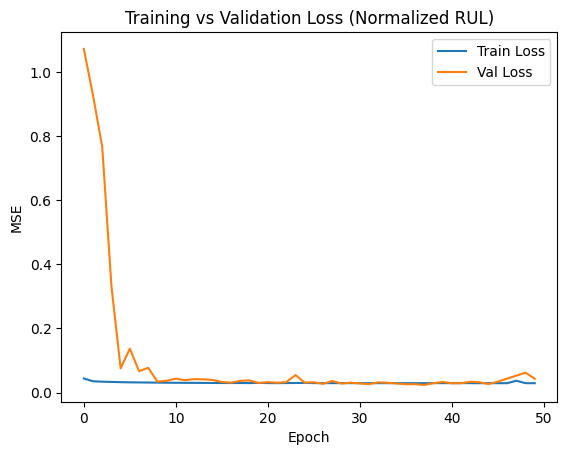

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training vs Validation Loss (Normalized RUL)')
plt.show()


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled  = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined